# PREPARATION

## Installation and Importing Library

In [ ]:
!pip install iterative-stratification transformers torch

from google.colab import drive
import pandas as pd
import numpy as np
import torch
from IPython.display import display
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import f1_score, classification_report
from torch.optim.lr_scheduler import StepLR
from scipy.stats import mode
from itertools import product
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time
import copy
import json
import os
import shutil
from google.colab import drive
from datasets import load_dataset, concatenate_datasets
from tqdm import tqdm

## Prepare and Download the Dataset

In [ ]:
dataset_name = "brighter-dataset/BRIGHTER-emotion-categories"
dataset = load_dataset(dataset_name, "ind")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

ind/dev-00000-of-00001.parquet:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

ind/test-00000-of-00001.parquet:   0%|          | 0.00/62.1k [00:00<?, ?B/s]

Generating dev split:   0%|          | 0/156 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/851 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    dev: Dataset({
        features: ['id', 'text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'emotions'],
        num_rows: 156
    })
    test: Dataset({
        features: ['id', 'text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'emotions'],
        num_rows: 851
    })
})


In [ ]:
full_dataset = concatenate_datasets([
    dataset["dev"],
    dataset["test"]
])

print(full_dataset)

Dataset({
    features: ['id', 'text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'emotions'],
    num_rows: 1007
})


## EDA

In [ ]:
df = full_dataset.to_pandas()

In [ ]:
display(df.head())

,id,text,anger,disgust,fear,joy,sadness,surprise,emotions
0,ind_dev_track_c_00001,"ekspresimu leh mas"", gokil , perbanyak tampara...",0,0,0,1,0,0,[joy]
1,ind_dev_track_c_00002,"brebes mili aku, semoga sllu sukses",0,0,0,1,0,0,[joy]
2,ind_dev_track_c_00003,cover terenak di lagu care bebek yg pernah say...,0,0,0,1,0,1,"[joy, surprise]"
3,ind_dev_track_c_00004,cewe yang joget² lagu ini ga ngerti bahasa sun...,0,1,0,0,0,1,"[disgust, surprise]"
4,ind_dev_track_c_00005,"hai gaiss, salam semua,nak tanya apa yang drum...",0,0,0,1,0,0,[joy]


In [ ]:
df = df.drop(columns=['emotions'])

In [ ]:
df.head()

,id,text,anger,disgust,fear,joy,sadness,surprise
0,ind_dev_track_c_00001,"ekspresimu leh mas"", gokil , perbanyak tampara...",0,0,0,1,0,0
1,ind_dev_track_c_00002,"brebes mili aku, semoga sllu sukses",0,0,0,1,0,0
2,ind_dev_track_c_00003,cover terenak di lagu care bebek yg pernah say...,0,0,0,1,0,1
3,ind_dev_track_c_00004,cewe yang joget² lagu ini ga ngerti bahasa sun...,0,1,0,0,0,1
4,ind_dev_track_c_00005,"hai gaiss, salam semua,nak tanya apa yang drum...",0,0,0,1,0,0


### Dataset Overview

In [ ]:
emotion_labels = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
avg_words = df['text'].str.split().str.len().mean()

print(f"Total samples: {len(df)}")
print(f"Number of emotion labels: {len(emotion_labels)}")
print(f"Average text length: {avg_words:.2f} words")

Total samples: 1007
Number of emotion labels: 6
Average text length: 13.33 words


### Check Missing Data or Noise

In [ ]:
# Check Empty Text (Null/NaN)
missing_values = df['text'].isnull().sum()

# Check Any 'Too' Short Text (Ex: <= 2 char)
# This catch "ok", "ya", or just spasi
short_text_counts = (df['text'].str.len() <= 2).sum()

# Check duplicate
duplicate_counts = df['text'].duplicated().sum()

print(f"Empty Text: {missing_values}")
print(f"Text <= 2 char: {short_text_counts}")
print(f"Duplicate Text: {duplicate_counts}")

total_data = len(df)

less_than_3_words = df[df['text'].apply(lambda x: len(str(x).split()) < 3)]
less_than_3_percentage = (len(less_than_3_words) / total_data) * 100
duplicates_percentage = (duplicate_counts / total_data) * 100

print(f"\nPercentage of text with less than 3 words: {less_than_3_percentage:.2f}%")
print(f"Percentage of duplicates: {duplicates_percentage:.2f}%")

Empty Text: 0
Text <= 2 char: 0
Duplicate Text: 0

Percentage of text with less than 3 words: 0.00%
Percentage of duplicates: 0.00%


### Label Distribution

#### Label Count per Sample

In [ ]:
def visualize_label_count(df):
  df['label_count'] = df[emotion_labels].sum(axis=1)

  plt.figure(figsize=(8, 5))
  plt.hist(df['label_count'], bins=range(0, len(emotion_labels) + 2),
          align='left', rwidth=0.8, color='skyblue', edgecolor='black')

  plt.title('Distribution of Label Count per Sample')
  plt.xlabel('Number of Emotions')
  plt.ylabel('Frequency')
  plt.xticks(range(0, len(emotion_labels) + 1))
  plt.grid(axis='y', alpha=0.3)

  plt.show()

  print(df['label_count'].value_counts().sort_index())

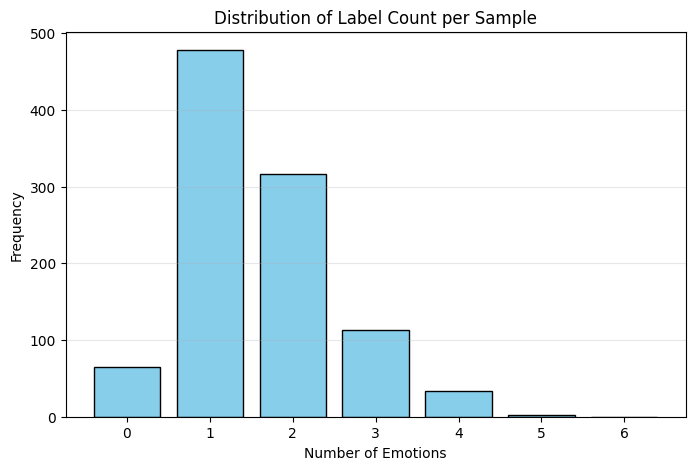

label_count
0     65
1    478
2    316
3    113
4     33
5      2
Name: count, dtype: int64


In [ ]:
visualize_label_count(df)

The distribution shows that most samples contain one or two emotion labels, with a clear peak at single-label instances. Samples with three or more emotions are significantly less frequent, and cases with four or more labels are rare.


This suggest that although the task is formulated as multi-label emotion classification, the dataset is dominated by low label cardinality, closer to a single-label ot lightly multi-label setting. There are also a small number of samples with zero labels, which may represent neutral or unannotated emotional content and should be handled carefully during training and evaluation.


Because the data is dominated by a single label, the model may tend to predict only one emotion. To address this, we need to ensure the loss function used is BCEWithLogitsLoss, which allows the model to objectively evaluate each emotion independently without being forced to choose only one (as with Softmax).


In [ ]:
# Check 5 example of texts with no label
print(df[df['label_count'] == 0]['text'].head(5))

53    hubungi nomor yg ada di bio instagram 3pemuda ...
54             hub instagram kita di 3pemuda _berbahaya
83       gw liat karna sering denger 3 pemuda berbahaya
93              14 detik yang lalu, apakah aku pertama?
98                 cover lagu element - maaf dari surga
Name: text, dtype: object


Around 65 samples were found with label_count = 0. Upon inspection, these samples are likely spam or lack clear emotional content.


These unlabeled samples were removed from the dataset to ensure the model only learns from valid emotional signals and avoids noise during training.

In [ ]:
# Remove samples with no labels to ensure the model learns from valid emotional cues
df = df[df['label_count'] > 0].reset_index(drop=True)

# Verify the result
print(f"Total samples after removal: {len(df)}")

Total samples after removal: 942


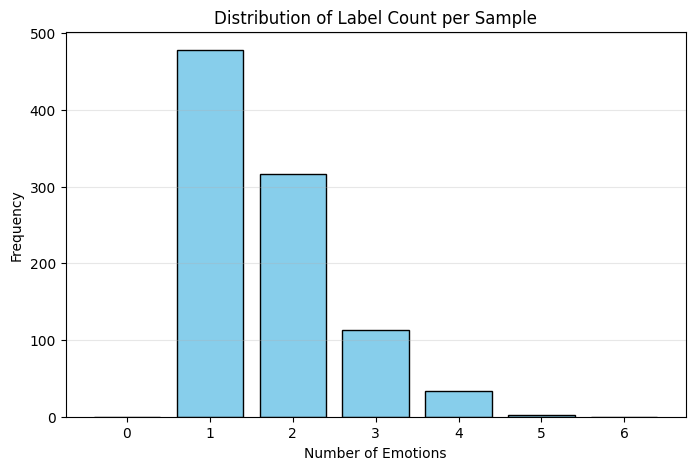

label_count
1    478
2    316
3    113
4     33
5      2
Name: count, dtype: int64


In [ ]:
visualize_label_count(df)

#### Frequency of Each Label (Class Distribution)

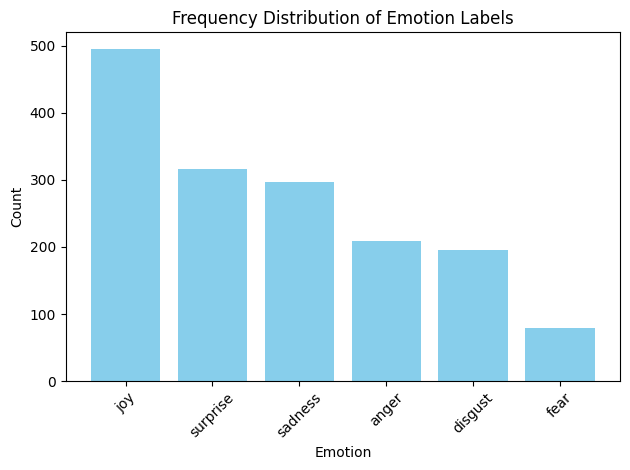

joy         495
surprise    316
sadness     296
anger       209
disgust     196
fear         79
dtype: int64


In [ ]:
emotion_counts = df[emotion_labels].sum().sort_values(ascending=False)
plt.bar(emotion_counts.index, emotion_counts.values, color='skyblue')
plt.title('Frequency Distribution of Emotion Labels')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/miniprojects/emo_detect_ina/distribusi_emosi.png')
plt.show()

print(emotion_counts)

There is a significant class imbalance. Joy (495) is the most dominant emotion, while Fear (79) has the fewest samples in the dataset.

The model will have a higher tendency (bias) to predict Joy due to its high frequency. Conversely, the model may have difficulty recognising patterns in Fear due to the limited number of examples learned.

This implicating we need to perform data splitting using Multilabel Stratified Shuffle Split to ensure that the distribution of rare emotions (such as Fear) remains fairly represented in the Train, Val, and Test sets. Additionally, during the evaluation stage, I will use Macro-F1 as the primary evaluation metric to account for label imbalance across emotions. By averaging performance equally across labels, it prevents dominant emotions from masking poor performance on rarer ones.

### Emotions Co-Occurrence

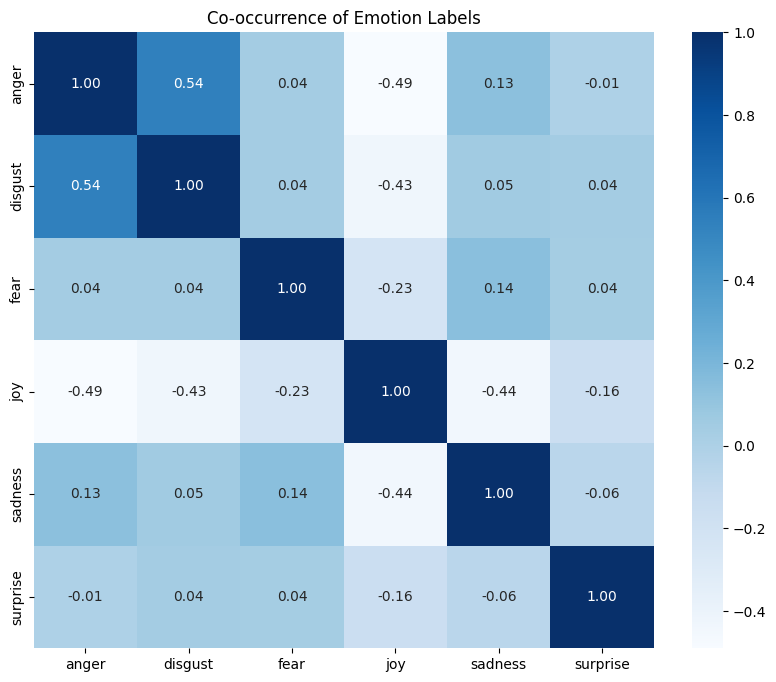

In [ ]:
emotion_cooccurrence = df[emotion_labels].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(emotion_cooccurrence, annot=True, cmap='Blues', fmt=".2f")
plt.title('Co-occurrence of Emotion Labels')
plt.savefig('/content/drive/MyDrive/miniprojects/emo_detect_ina/emotion_cooccurrence.png')

The visualization above shows a strong positive relationship between Anger and Disgust (0.54), as well as a moderate positive relationship between Fear and several other negative emotions. Conversely, Joy shows a consistent negative correlation with almost all other emotions (e.g., Joy vs. Anger: -0.49).

This indicates that emotions in the dataset tend to appear logically and in clusters. The co-occurrence of Anger and Disgust is a common pattern in opinion or complaint texts, while Joy tends to be exclusive—meaning that if a text is already happy, it is less likely to contain negative emotions.

The IndoBERT model must be able to capture the "double nuances" of correlated emotions. Using BCEWithLogitsLoss is particularly appropriate here because it allows the model to assign high probabilities to two emotions simultaneously (e.g., Anger & Disgust) without canceling each other out, as with the Softmax function.

### Token Length Distribution

In [ ]:
# Initialize the IndoBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

def count_tokens(text):
  return len(tokenizer.encode(text, add_special_tokens=True))

df['token_count'] = df['text'].apply(count_tokens)

stats = {
    'Mean': df['token_count'].mean(),
    'Median': df['token_count'].median(),
    '95th Percentile': np.percentile(df['token_count'], 95),
    'Max': df['token_count'].max()
}

print("Token Count Statistics:")
for key, value in stats.items():
    print(f"{key}: {value:.2f}")

Token Count Statistics:
Mean: 19.30
Median: 16.00
95th Percentile: 41.00
Max: 69.00


The text length distribution shows that most comments or sentences are quite short, with the 95th percentile being around 49 tokens. The maximum text length is 69 tokens, but the frequency of texts exceeding 60 tokens is very low.

Indonesian texts in this dataset tend to be short and concise. Emotional information is usually concentrated at the beginning or middle of a sentence, so very long paragraphs of context are unnecessary.

For the modeling later, I set max_length = 64. This decision optimizes GPU memory efficiency and speeds up the training process without cutting out important information (sacrificing only <5% of the very long data).